# Data Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Get the nec
from fastai.vision.all import *
from utils import *
from collections import Counter
path = untar_data(URLs.PASCAL_2007)

In [5]:
# Read the dataframe containing all the data
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
train_df = df[~df.is_valid].reset_index(drop = True)
len(train_df)

2501

In [7]:
allLabels = train_df.labels.apply(lambda x: x.split(" ")).tolist()

lblCounts = Counter()
for lblList in allLabels:
    for lbl in lblList:
        lblCounts[lbl] += 1

df1 = pd.DataFrame(dict(lblCounts), index = ["Counts"]).T.reset_index()
df1.columns = ["Category", "Counts"]

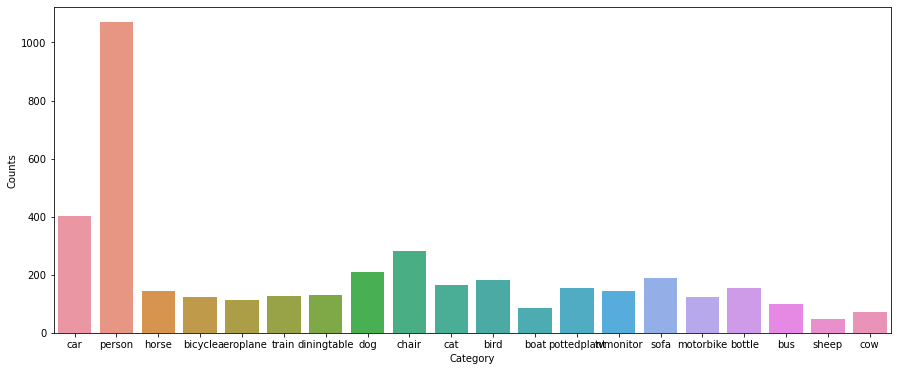

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
sns.barplot(data = df1, x = "Category", y = "Counts", ax = ax);

In [9]:
df1.Counts.sum()

4017

In [10]:
# Define the getter for independent variable
def get_x(row): return path/'train'/row['fname']

# Define the getter for dependent variable
def get_y(row): return row['labels'].split(" ")

# Define how to split the data into train and validation
def splitter(df):
    valid_idxs = df[(df.is_valid == True)].index.tolist()
    train_idxs = df[(df.is_valid == False)].index.tolist()
    return (train_idxs, valid_idxs)

In [11]:
# Define a multicategory block with presizing
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(460, min_scale=0.35),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )

In [12]:
dls = dblock.dataloaders(df, bs = 32)

In [13]:
len(dls.train_ds), len(dls.valid_ds)

(2501, 2510)

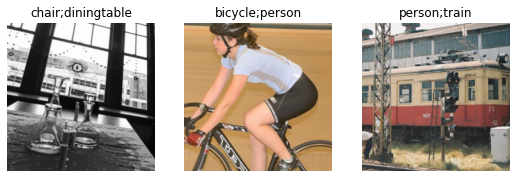

In [33]:
dls.show_batch(nrows=1, ncols=3)

# Model Training

SuggestedLRs(valley=0.0020892962347716093)

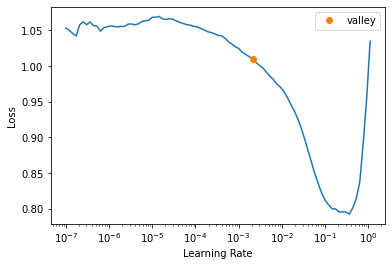

In [9]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.lr_find()

In [33]:
learn.fine_tune(epochs = 5, freeze_epochs = 5, base_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.958741,0.711043,0.605359,00:58
1,0.844710,0.613608,0.684462,00:49
2,0.712436,0.471373,0.803586,00:49
3,0.474204,0.200284,0.956255,00:49
4,0.250536,0.104573,0.968825,00:49


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134554,0.087946,0.972012,01:00
1,0.117358,0.083584,0.971534,00:59
2,0.103699,0.076457,0.973347,00:59
3,0.085033,0.074564,0.974044,00:59
4,0.075196,0.073999,0.974143,00:59


In [248]:
learn.export("mlcClassification.pkl")

In [15]:
learn = load_learner("mlcClassification.pkl")
learn.dls = dls

# Threshold selection

In [16]:
predictions, targets = learn.get_preds()

In [17]:
predictions.shape, targets.shape

(torch.Size([2510, 20]), torch.Size([2510, 20]))

In [18]:
predictions[0], targets[0]

(tensor([3.2416e-03, 9.6696e-03, 4.8257e-03, 1.7395e-03, 2.1805e-02, 4.5078e-03,
         2.1510e-03, 1.1448e-02, 9.6224e-01, 9.2060e-04, 4.0102e-01, 3.3630e-03,
         6.3034e-04, 4.8359e-04, 7.0404e-02, 3.9611e-02, 2.9567e-03, 2.5995e-01,
         1.8950e-03, 8.3430e-02]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [19]:
(torch.all((predictions >= 0.5) * 1. == targets, axis = 1)* 1.).mean()

TensorMultiCategory(0.6124)

In [20]:
((predictions >= 0.5) * 1. == targets).float().mean()

TensorMultiCategory(0.9741)

## Global thresholding

In [21]:
def threshold(preds, targets):
    # Define 100 thresholds equally spaced from 0 to 1
    thresholds = np.arange(0, 1, 0.01)
    
    # Create a mapping from threshold to accuracies
    thresholdAccuracyMapping = {}
    for thresh in thresholds:
        thresholdAccuracyMapping[thresh] = accuracy_multi(preds, targets, thresh = thresh, sigmoid = False).item()
    
    # Create a dataframe out of the above mapping
    df = pd.DataFrame(thresholdAccuracyMapping, index = ["Accuracy"]).T.reset_index()
    df.columns = ["Threshold", "Accuracy"]

    # Make a plot
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    sns.lineplot(data = df, x = "Threshold", y = "Accuracy", ax = ax)
    fig.suptitle("Accuracy at different thresholds", fontsize = 24)
    fig.tight_layout();

    # Plot the best threshold
    bestThreshold = df[df.Accuracy == df.Accuracy.max()]
    bestThr = bestThreshold.Threshold.item()
    bestAcc = bestThreshold.Accuracy.item()
    ax.scatter(bestThr, bestAcc, c = "red");

    # Return the best Threshold
    return (bestThr, bestAcc)

(0.62, 0.9746015667915344)

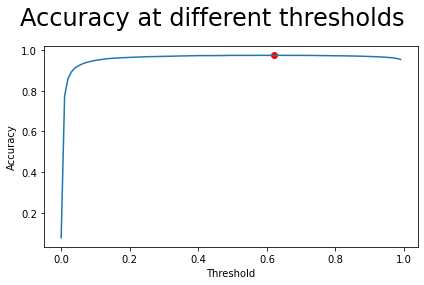

In [22]:
threshold(predictions, targets)

## Local thresholding and then combining

In [26]:
dls.vocab[5]

'bus'

{'bestF1_Point': [0.33, 0.9832669322709163],
 'bestAcc_Point': [0.4, 0.9836653386454183],
 'closest_Point': [0.04, 0.9442231075697212]}

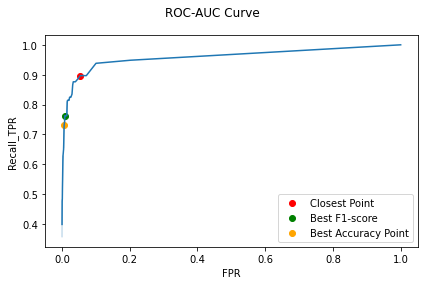

In [25]:
utils.getSummary(predictions[:, 5], targets[:, 5])

In [17]:
# With max accuracy strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "Accuracy")

0.9758167266845703

In [18]:
# With max f1Score strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "f1Score")

0.9749601483345032

In [19]:
# With closest point strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "Closest")

0.9363346695899963